In [1]:
from modules import init, pump, regen, heater, turbine, condenser
import pandas as pd
import prop

#Таблицы с потоками и блоками:
streams = pd.read_excel("data.xlsx", sheet_name = "streams", index_col=0)
blocks  = pd.read_excel("data.xlsx", sheet_name = "blocks",  index_col=0)

#Параметры нагревающей среды:
streams.loc["IN-HEAT", "G"] = 509
gas  = "REFPROP::N2[0.78]&O2[0.1]&CO2[0.02]&H2O[0.1]"
Tin  = 183.6
Pgas = 0.1
Tout = 80

#Параметры охлаждающей среды:
streams.loc["IN-COND", "G"] = 1000
fluidcond  = "REFPROP::WATER"
Tfluidcond = 15
Pfluidcond = 0.15

#Параметры ОЦР:
streams.loc["COND-PUMP", "G"] = 1000
fluid   = "REFPROP::R236ea"
KPDpump = 0.85
KPDturb = 0.85
DTheat  = 10
DTcond  = 5
Pcond   = prop.t_q(30,0,fluid)["P"]
Ppump   = 3.3

#Внесение входных данных в таблицу:
streams.loc["IN-HEAT",   "T":"Q"] = list(prop.t_p(Tin,        Pgas,       gas)      .values())
streams.loc["IN-COND",   "T":"Q"] = list(prop.t_p(Tfluidcond, Pfluidcond, fluidcond).values())
streams.loc["COND-PUMP", "T":"Q"] = list(prop.p_q(Pcond,      0,          fluid)    .values())

#Итеративный расчет для сведения баланса:
init(streams, blocks, fluid, gas, fluidcond)
for i in range(9999):
    
    pump.calc     ("COND-PUMP", "REG-HEAT",                           Ppump, KPDpump)
    heater.calc   ("IN-HEAT",   "HEAT-OUT",  "REG-HEAT", "HEAT-TURB", Tout,  DTheat )
    turbine.calc  ("HEAT-TURB", "REG-COND",                           Pcond, KPDturb)
    condenser.calc("REG-COND",  "COND-PUMP", "IN-COND",  "COND-OUT",         DTcond )

    Qbalance = (blocks.loc["HEATER","Q"] + blocks.loc["PUMP","N"] - blocks.loc["CONDENSER","Q"] - blocks.loc["TURBINE","N"])/blocks.loc["HEATER","Q"]
    if abs(Qbalance) < 10**-4:
        break

KPD = (blocks.loc["TURBINE","N"] - blocks.loc["PUMP","N"])/blocks.loc["HEATER","Q"]
print("KPD:",round(KPD*100, 5))

KPD: 15.20172


In [2]:
streams

,T,P,H,S,Q,G
IN-HEAT,183.600000,0.100000,628.266954,7.349244,1.0,509.000000
HEAT-OUT,80.000000,0.100000,515.655043,7.069707,1.0,509.000000
COND-PUMP,30.000000,0.244324,237.395788,1.129466,0.0,234.935940
PUMP-REG,NaN,NaN,NaN,NaN,NaN,NaN
REG-HEAT,31.481898,3.300000,239.936592,1.130717,0.0,234.935940
HEAT-TURB,159.534706,3.300000,483.915709,1.777164,1.0,234.935940
TURB-REG,NaN,NaN,NaN,NaN,NaN,NaN
REG-COND,87.704828,0.244324,444.285894,1.796742,1.0,234.935940
IN-COND,15.000000,0.150000,63.123431,0.224441,0.0,813.162737
COND-OUT,29.289539,0.150000,122.897347,0.426903,0.0,813.162737


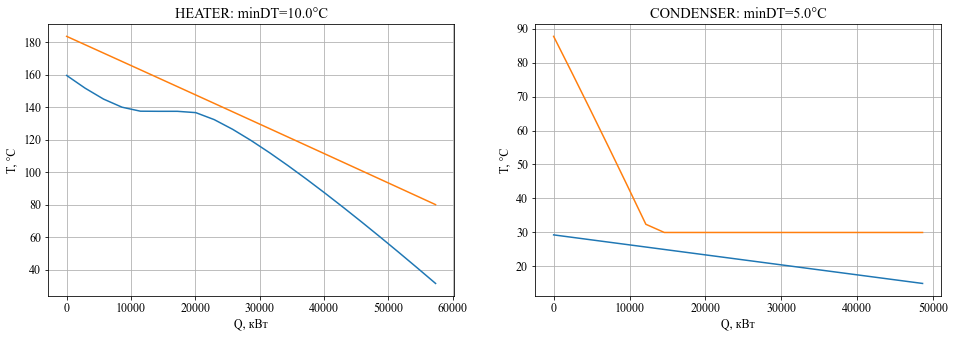

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
heater.TQ("IN-HEAT", "HEAT-OUT", "REG-HEAT", "HEAT-TURB")
plt.subplot(1, 2, 2)
condenser.TQ("REG-COND", "COND-PUMP", "IN-COND", "COND-OUT")
plt.show()